<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/seblock2_50epoch_flower_D_se_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.0 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 69.1MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf, se = True )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, se = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, se = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:10<00:00,  1.46it/s]


epoch: 0, lossD:0.7389881656080195, lossG:11.846836678032735,lossG_fake:8.226094931074716, lossG_real:3.620741692561548 ,equality:4.6053532385131675


evaluate:122.97792053222656,kid_mean:0.07894439995288849, kid_std:0.01876477710902691,kid_:(tensor(0.0789), tensor(0.0188))


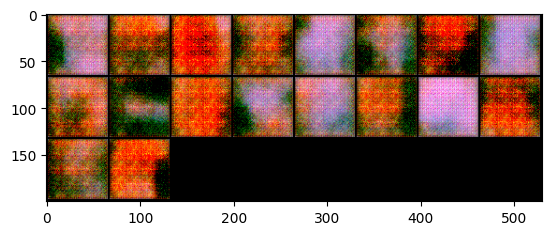

100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


epoch: 1, lossD:0.7448041173403414, lossG:6.791139644326516,lossG_fake:3.9341780939727156, lossG_real:2.8569615170793625 ,equality:1.077216576893353


evaluate:123.67308044433594,kid_mean:0.08503773808479309, kid_std:0.03303486853837967,kid_:(tensor(0.0850), tensor(0.0330))


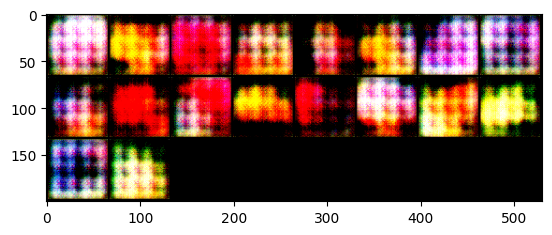

100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


epoch: 2, lossD:1.1004719240862189, lossG:6.362025279443241,lossG_fake:3.9084362891113873, lossG_real:2.453588976877407 ,equality:1.4548473122339804


evaluate:122.7540283203125,kid_mean:0.08423057198524475, kid_std:0.04026983678340912,kid_:(tensor(0.0842), tensor(0.0403))


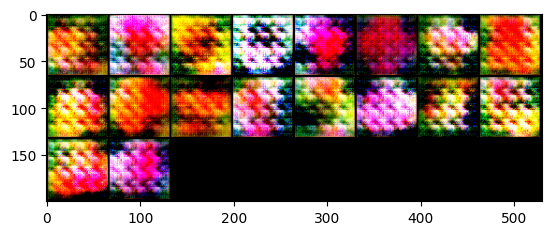

100%|██████████| 103/103 [00:09<00:00, 10.84it/s]


epoch: 3, lossD:0.9622857020173258, lossG:6.317498568192269,lossG_fake:3.8295476540778446, lossG_real:2.48795094420609 ,equality:1.3415967098717547


evaluate:118.34841918945312,kid_mean:0.07645194977521896, kid_std:0.03506825864315033,kid_:(tensor(0.0765), tensor(0.0351))


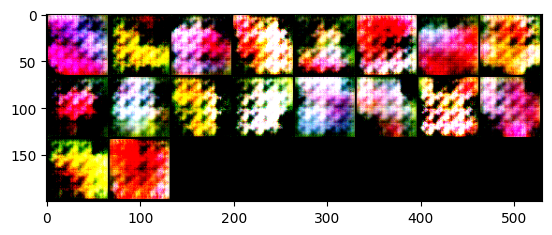

100%|██████████| 103/103 [00:09<00:00, 11.34it/s]


epoch: 4, lossD:0.8516319696475001, lossG:6.36696235416005,lossG_fake:3.81638210954018, lossG_real:2.5505802318887802 ,equality:1.2658018776513997


evaluate:115.45808410644531,kid_mean:0.07705941796302795, kid_std:0.03661732003092766,kid_:(tensor(0.0771), tensor(0.0366))


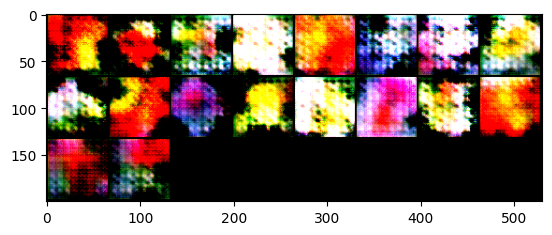

100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


epoch: 5, lossD:0.8331472838966592, lossG:6.330884868658862,lossG_fake:3.757079766792001, lossG_real:2.573805098105403 ,equality:1.183274668686598


evaluate:122.76691436767578,kid_mean:0.08403194695711136, kid_std:0.0425955131649971,kid_:(tensor(0.0840), tensor(0.0426))


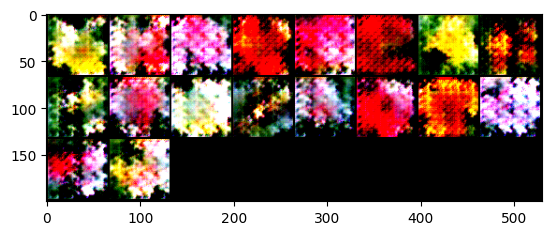

100%|██████████| 103/103 [00:09<00:00, 10.60it/s]


epoch: 6, lossD:0.9433180634836549, lossG:5.936134278195576,lossG_fake:3.5050512633277373, lossG_real:2.431083000400691 ,equality:1.0739682629270462


evaluate:127.31792449951172,kid_mean:0.08884891867637634, kid_std:0.040234316140413284,kid_:(tensor(0.0888), tensor(0.0402))


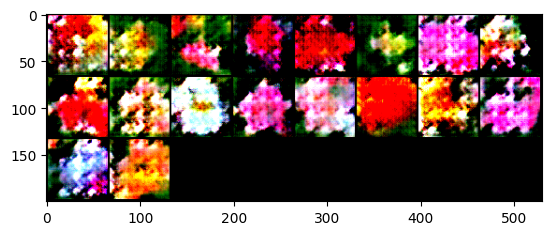

100%|██████████| 103/103 [00:09<00:00, 10.55it/s]


epoch: 7, lossD:0.9246759990465294, lossG:5.989535067845317,lossG_fake:3.516054176589818, lossG_real:2.47348090514396 ,equality:1.0425732714458578


evaluate:123.6355209350586,kid_mean:0.07958731800317764, kid_std:0.037712614983320236,kid_:(tensor(0.0796), tensor(0.0377))


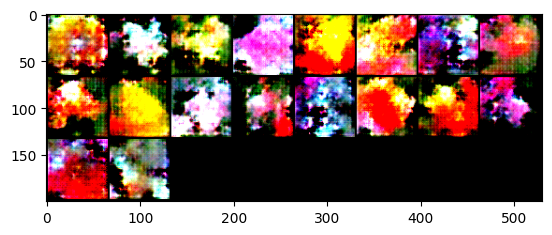

100%|██████████| 103/103 [00:09<00:00, 10.83it/s]


epoch: 8, lossD:1.012813217720939, lossG:5.621263008673214,lossG_fake:3.2860101588721413, lossG_real:2.3352528648469053 ,equality:0.950757294025236


evaluate:124.88078308105469,kid_mean:0.0809914767742157, kid_std:0.04372537136077881,kid_:(tensor(0.0810), tensor(0.0437))


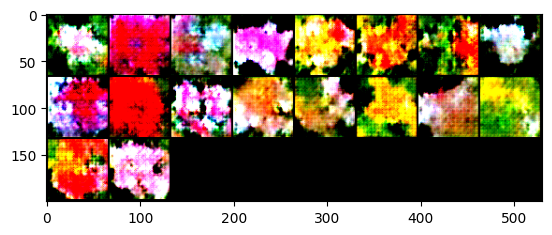

100%|██████████| 103/103 [00:09<00:00, 10.90it/s]


epoch: 9, lossD:1.1281979240260078, lossG:5.240076588195505,lossG_fake:3.0113829200707594, lossG_real:2.228693690982837 ,equality:0.7826892290879224


evaluate:124.76399230957031,kid_mean:0.08738704770803452, kid_std:0.03883395716547966,kid_:(tensor(0.0874), tensor(0.0388))


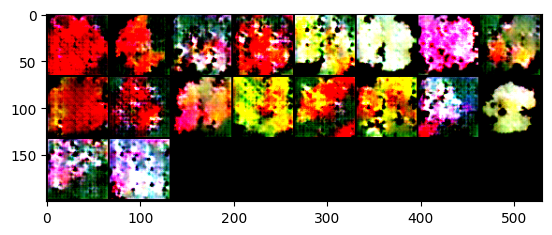

100%|██████████| 103/103 [00:09<00:00, 10.70it/s]


epoch: 10, lossD:1.1388267498571896, lossG:4.983109006603945,lossG_fake:2.8444067772152355, lossG_real:2.1387022137641907 ,equality:0.7057045634510448


evaluate:115.08976745605469,kid_mean:0.08464159071445465, kid_std:0.03931408002972603,kid_:(tensor(0.0846), tensor(0.0393))


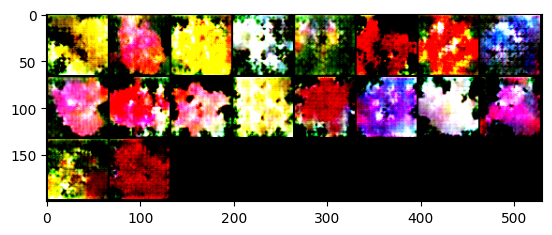

100%|██████████| 103/103 [00:09<00:00, 10.61it/s]


epoch: 11, lossD:1.1317048813532857, lossG:5.012772148095288,lossG_fake:2.810943469260503, lossG_real:2.201828667839754 ,equality:0.6091148014207488


evaluate:111.8262710571289,kid_mean:0.0778699517250061, kid_std:0.04019058868288994,kid_:(tensor(0.0779), tensor(0.0402))


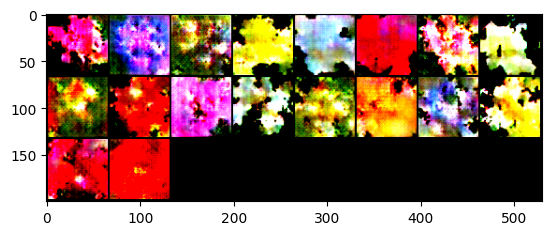

100%|██████████| 103/103 [00:09<00:00, 10.88it/s]


epoch: 12, lossD:1.08644078454925, lossG:5.057347260632561,lossG_fake:2.7995272909553304, lossG_real:2.257819989931236 ,equality:0.5417073010240943


evaluate:112.05317687988281,kid_mean:0.08392012864351273, kid_std:0.044153738766908646,kid_:(tensor(0.0839), tensor(0.0442))


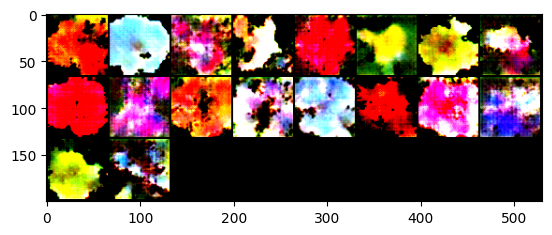

100%|██████████| 103/103 [00:09<00:00, 10.78it/s]


epoch: 13, lossD:1.006533903115004, lossG:5.196154719417535,lossG_fake:2.8733556768269213, lossG_real:2.32279903043821 ,equality:0.5505566463887113


evaluate:106.49838256835938,kid_mean:0.07833130657672882, kid_std:0.040341053158044815,kid_:(tensor(0.0783), tensor(0.0403))


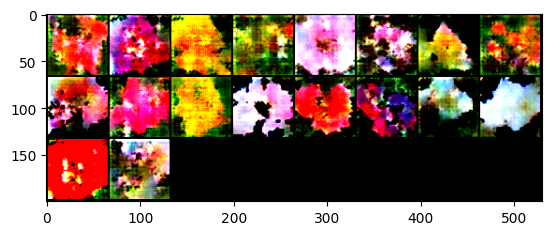

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 14, lossD:0.9750012246150415, lossG:5.29810790645266,lossG_fake:2.879184356013548, lossG_real:2.4189235579620285 ,equality:0.4602607980515194


evaluate:105.23501586914062,kid_mean:0.07449743896722794, kid_std:0.03928353264927864,kid_:(tensor(0.0745), tensor(0.0393))


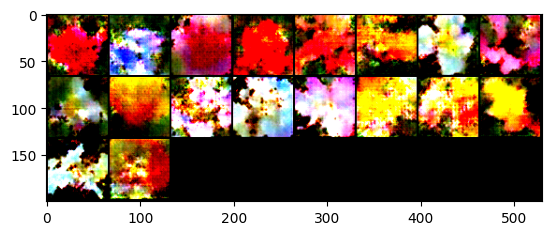

100%|██████████| 103/103 [00:09<00:00, 10.70it/s]


epoch: 15, lossD:0.9543086165942035, lossG:5.382320519789909,lossG_fake:2.9715831025132857, lossG_real:2.410737446210917 ,equality:0.5608456563023689


evaluate:103.69398498535156,kid_mean:0.06854356080293655, kid_std:0.03656022623181343,kid_:(tensor(0.0685), tensor(0.0366))


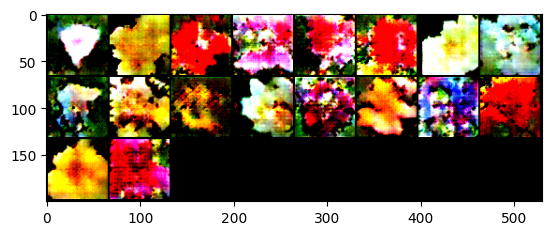

100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


epoch: 16, lossD:0.9002877832616417, lossG:5.440203958344691,lossG_fake:2.9525138035561276, lossG_real:2.487690161154108 ,equality:0.46482364240201957


evaluate:108.70478820800781,kid_mean:0.06534392386674881, kid_std:0.034991029649972916,kid_:(tensor(0.0653), tensor(0.0350))


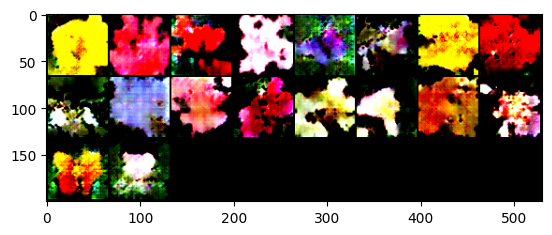

100%|██████████| 103/103 [00:09<00:00, 11.01it/s]


epoch: 17, lossD:0.8797900089361135, lossG:5.606604381672387,lossG_fake:3.0952579645277227, lossG_real:2.511346419170065 ,equality:0.5839115453576578


evaluate:110.3923110961914,kid_mean:0.07622205466032028, kid_std:0.04016092047095299,kid_:(tensor(0.0762), tensor(0.0402))


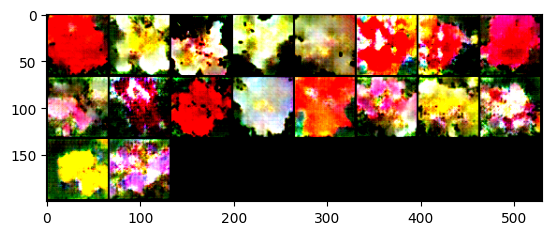

100%|██████████| 103/103 [00:09<00:00, 10.64it/s]


epoch: 18, lossD:0.8212420937505741, lossG:5.730920819402899,lossG_fake:3.1366264982130923, lossG_real:2.5942943304487804 ,equality:0.5423321677643118


evaluate:111.23164367675781,kid_mean:0.07830426841974258, kid_std:0.04197138547897339,kid_:(tensor(0.0783), tensor(0.0420))


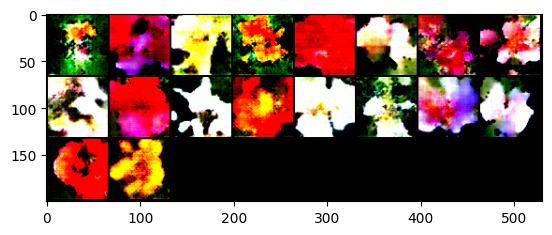

100%|██████████| 103/103 [00:10<00:00, 10.23it/s]


epoch: 19, lossD:0.7518007068090069, lossG:5.8732008563662035,lossG_fake:3.21562303559294, lossG_real:2.6575777848947397 ,equality:0.5580452506982003


evaluate:111.74676513671875,kid_mean:0.07404599338769913, kid_std:0.04411974549293518,kid_:(tensor(0.0740), tensor(0.0441))


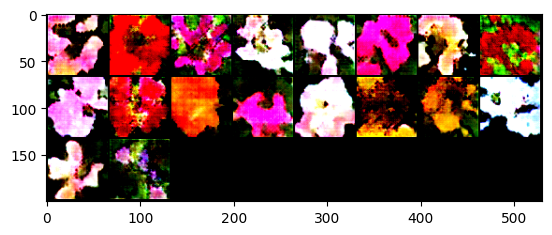

100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


epoch: 20, lossD:0.7626932792871901, lossG:5.843012425505999,lossG_fake:3.132099210637287, lossG_real:2.7109132073457958 ,equality:0.42118600329149114


evaluate:111.66448974609375,kid_mean:0.07486803084611893, kid_std:0.04176025092601776,kid_:(tensor(0.0749), tensor(0.0418))


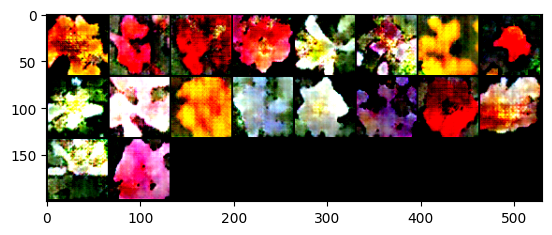

100%|██████████| 103/103 [00:09<00:00, 10.38it/s]


epoch: 21, lossD:0.649450848475822, lossG:5.998963601380876,lossG_fake:3.2104398243635606, lossG_real:2.788523774702572 ,equality:0.4219160496609886


evaluate:113.34063720703125,kid_mean:0.07955548167228699, kid_std:0.040936220437288284,kid_:(tensor(0.0796), tensor(0.0409))


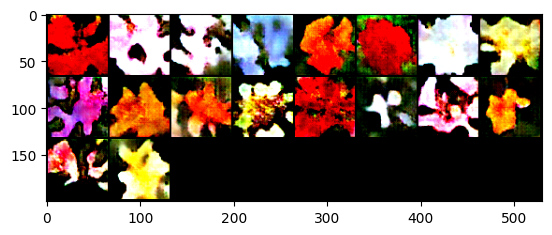

100%|██████████| 103/103 [00:09<00:00, 10.69it/s]


epoch: 22, lossD:0.6709800717032072, lossG:6.1163011060177706,lossG_fake:3.2761193409706784, lossG_real:2.840181745950458 ,equality:0.4359375950202202


evaluate:112.86542510986328,kid_mean:0.0730200856924057, kid_std:0.041663844138383865,kid_:(tensor(0.0730), tensor(0.0417))


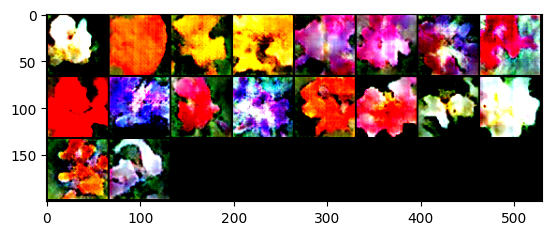

100%|██████████| 103/103 [00:09<00:00, 10.53it/s]


epoch: 23, lossD:0.6090523655553466, lossG:6.17891334329994,lossG_fake:3.332323251418697, lossG_real:2.8465900750993525 ,equality:0.48573317631934465


evaluate:112.11615753173828,kid_mean:0.07478271424770355, kid_std:0.038597263395786285,kid_:(tensor(0.0748), tensor(0.0386))


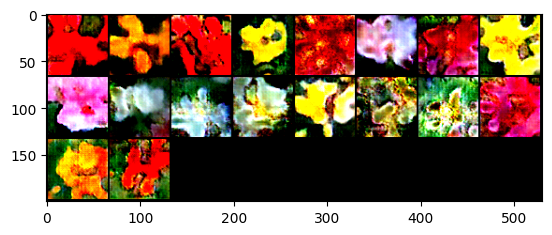

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 24, lossD:0.6439879538798795, lossG:6.1312042671499905,lossG_fake:3.2243176368833746, lossG_real:2.906886614063411 ,equality:0.3174310228199637


evaluate:112.15213012695312,kid_mean:0.07631764560937881, kid_std:0.036826346069574356,kid_:(tensor(0.0763), tensor(0.0368))


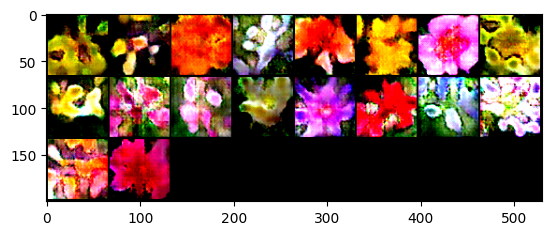

100%|██████████| 103/103 [00:09<00:00, 10.54it/s]


epoch: 25, lossD:0.5403587672027569, lossG:6.181447510580415,lossG_fake:3.286723882249258, lossG_real:2.894723631803272 ,equality:0.3920002504459861


evaluate:112.10323333740234,kid_mean:0.07508983463048935, kid_std:0.040394507348537445,kid_:(tensor(0.0751), tensor(0.0404))


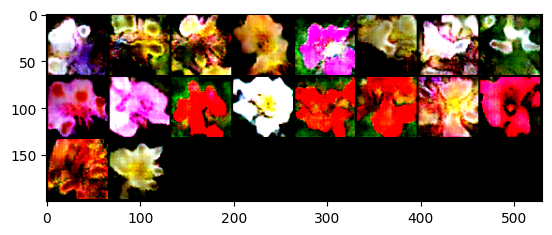

100%|██████████| 103/103 [00:09<00:00, 10.65it/s]


epoch: 26, lossD:0.5704793220440161, lossG:6.365554985490817,lossG_fake:3.390487915682561, lossG_real:2.9750670599705966 ,equality:0.4154208557119645


evaluate:112.18745422363281,kid_mean:0.06457243114709854, kid_std:0.03221864998340607,kid_:(tensor(0.0646), tensor(0.0322))


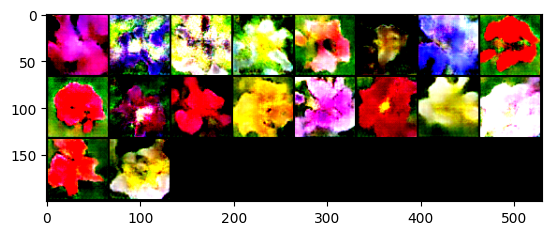

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 27, lossD:0.49445841540989366, lossG:6.4589042385805,lossG_fake:3.458491649731849, lossG_real:3.0004125827724493 ,equality:0.4580790669593999


evaluate:113.32652282714844,kid_mean:0.07071998715400696, kid_std:0.038652826100587845,kid_:(tensor(0.0707), tensor(0.0387))


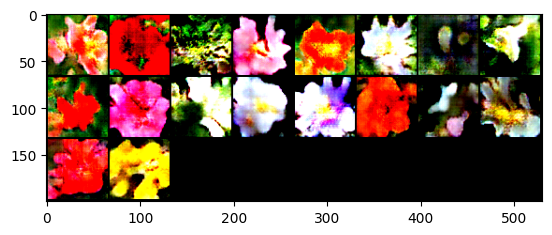

100%|██████████| 103/103 [00:09<00:00, 10.47it/s]


epoch: 28, lossD:0.48117216864546525, lossG:6.533918227964235,lossG_fake:3.4829876353439775, lossG_real:3.0509305769957384 ,equality:0.43205705834823904


evaluate:114.11856079101562,kid_mean:0.0713644027709961, kid_std:0.03995314985513687,kid_:(tensor(0.0714), tensor(0.0400))


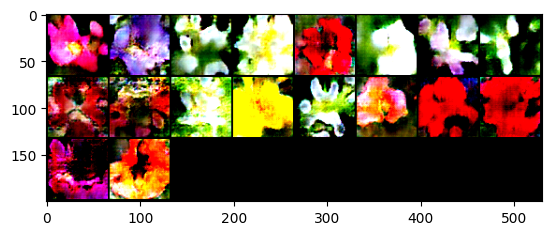

100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


epoch: 29, lossD:0.5152056466751885, lossG:6.7054349195609975,lossG_fake:3.655318012515318, lossG_real:3.0501169180407106 ,equality:0.6052010944746073


evaluate:114.4583969116211,kid_mean:0.06512577831745148, kid_std:0.038473423570394516,kid_:(tensor(0.0651), tensor(0.0385))


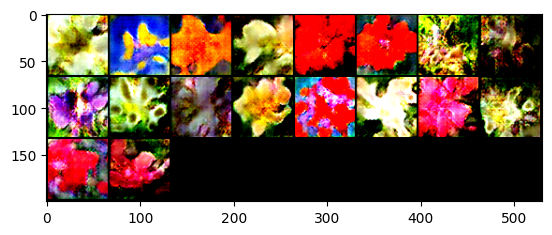

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 30, lossD:0.4430387239288358, lossG:6.803877187006682,lossG_fake:3.6513697302457198, lossG_real:3.1525074648625644 ,equality:0.49886226538315537


evaluate:115.84598541259766,kid_mean:0.07232905179262161, kid_std:0.03721259534358978,kid_:(tensor(0.0723), tensor(0.0372))


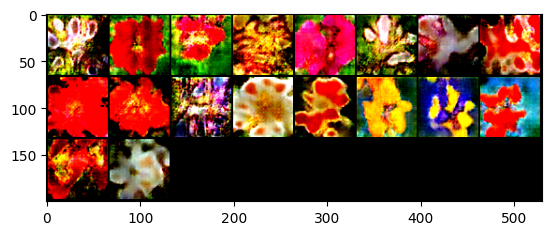

100%|██████████| 103/103 [00:09<00:00, 10.77it/s]


epoch: 31, lossD:0.4416392338507384, lossG:6.906765775773132,lossG_fake:3.701207973424671, lossG_real:3.205557783830513 ,equality:0.49565018959415763


evaluate:105.66563415527344,kid_mean:0.07668832689523697, kid_std:0.03848464414477348,kid_:(tensor(0.0767), tensor(0.0385))


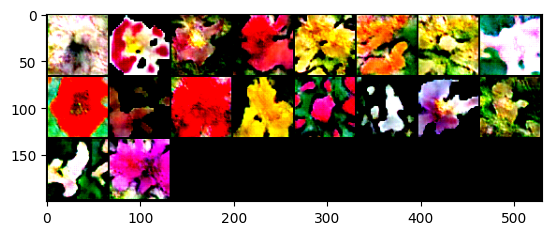

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 32, lossD:0.3604660152267773, lossG:6.968806484370556,lossG_fake:3.7246010754872296, lossG_real:3.244205428558646 ,equality:0.4803956469285837


evaluate:101.28767395019531,kid_mean:0.0805685818195343, kid_std:0.0479278564453125,kid_:(tensor(0.0806), tensor(0.0479))


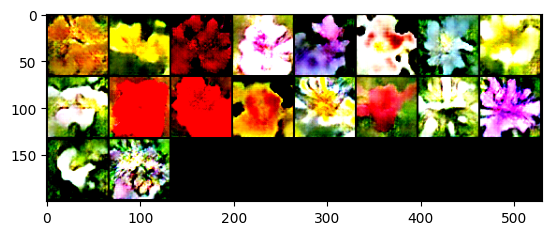

100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


epoch: 33, lossD:0.36883826618923726, lossG:7.386879870035116,lossG_fake:3.9998856748192058, lossG_real:3.386994179012706 ,equality:0.6128914958064997


evaluate:98.31484985351562,kid_mean:0.07291344553232193, kid_std:0.03914817050099373,kid_:(tensor(0.0729), tensor(0.0391))


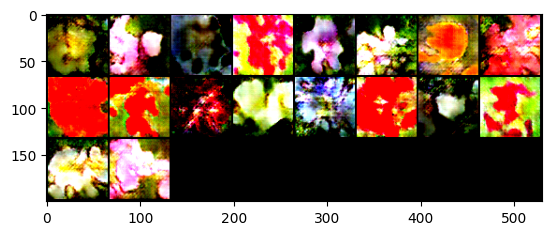

100%|██████████| 103/103 [00:09<00:00, 10.50it/s]


epoch: 34, lossD:0.34304289400432875, lossG:7.205880530829568,lossG_fake:3.873682046978219, lossG_real:3.332198484430035 ,equality:0.541483562548184


evaluate:94.98609924316406,kid_mean:0.07060681283473969, kid_std:0.03979568928480148,kid_:(tensor(0.0706), tensor(0.0398))


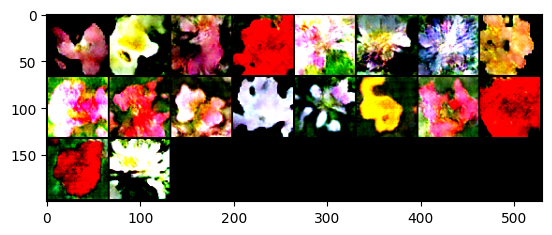

100%|██████████| 103/103 [00:09<00:00, 10.58it/s]


epoch: 35, lossD:0.3247455979145846, lossG:7.37603794949726,lossG_fake:3.9752659855537043, lossG_real:3.400771967415671 ,equality:0.5744940181380334


evaluate:93.8278579711914,kid_mean:0.07373840361833572, kid_std:0.04086966812610626,kid_:(tensor(0.0737), tensor(0.0409))


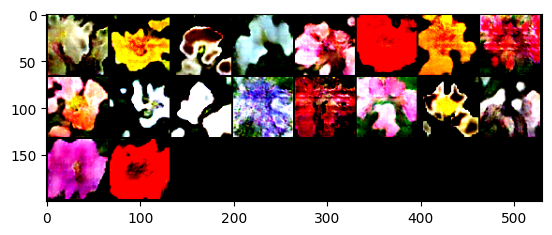

100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


epoch: 36, lossD:0.33743437184292135, lossG:7.405732145587217,lossG_fake:3.97336699430225, lossG_real:3.432365146655481 ,equality:0.5410018476467688


evaluate:93.62396240234375,kid_mean:0.06889539957046509, kid_std:0.04482780769467354,kid_:(tensor(0.0689), tensor(0.0448))


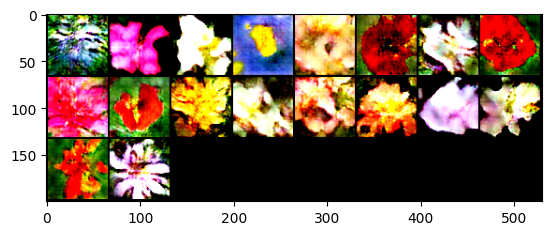

100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


epoch: 37, lossD:0.3438511688298392, lossG:7.350817481290947,lossG_fake:3.9638144194501117, lossG_real:3.3870030954046157 ,equality:0.576811324045496


evaluate:92.44131469726562,kid_mean:0.0733722373843193, kid_std:0.04493081942200661,kid_:(tensor(0.0734), tensor(0.0449))


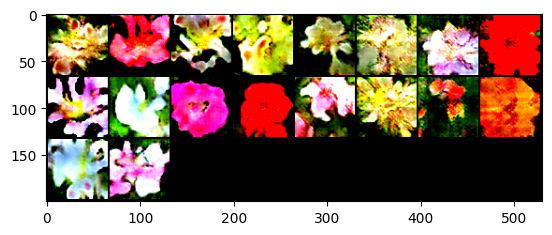

100%|██████████| 103/103 [00:10<00:00, 10.28it/s]


epoch: 38, lossD:0.40429733302986737, lossG:7.589500779087103,lossG_fake:4.107779286440136, lossG_real:3.481721481651936 ,equality:0.6260578047882004


evaluate:88.55429077148438,kid_mean:0.07473760098218918, kid_std:0.039474695920944214,kid_:(tensor(0.0747), tensor(0.0395))


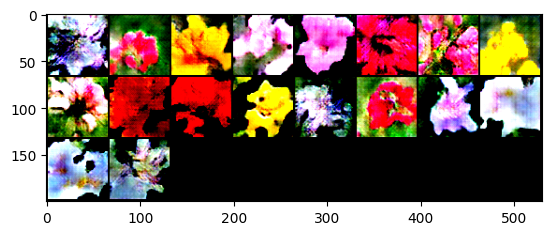

100%|██████████| 103/103 [00:09<00:00, 10.56it/s]


epoch: 39, lossD:0.3450938815847763, lossG:7.326670952213621,lossG_fake:3.907519202787899, lossG_real:3.4191517361159462 ,equality:0.48836746667195285


evaluate:86.65434265136719,kid_mean:0.06828854233026505, kid_std:0.04448147490620613,kid_:(tensor(0.0683), tensor(0.0445))


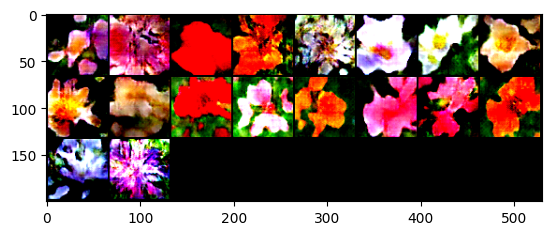

100%|██████████| 103/103 [00:09<00:00, 10.40it/s]


epoch: 40, lossD:0.36924711124772586, lossG:7.573985201641194,lossG_fake:4.027560619474615, lossG_real:3.546424552074914 ,equality:0.48113606739970116


evaluate:84.98869323730469,kid_mean:0.06421896815299988, kid_std:0.03759624809026718,kid_:(tensor(0.0642), tensor(0.0376))


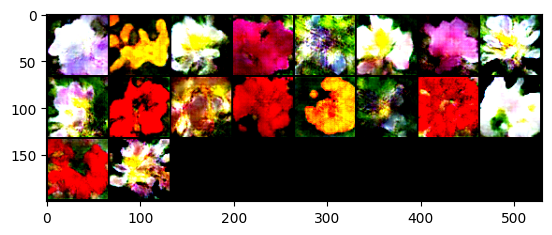

100%|██████████| 103/103 [00:09<00:00, 10.45it/s]


epoch: 41, lossD:0.305477809920473, lossG:7.435253916434871,lossG_fake:3.963819033891252, lossG_real:3.471434866919101 ,equality:0.49238416697215115


evaluate:85.13137817382812,kid_mean:0.07261548936367035, kid_std:0.04148406535387039,kid_:(tensor(0.0726), tensor(0.0415))


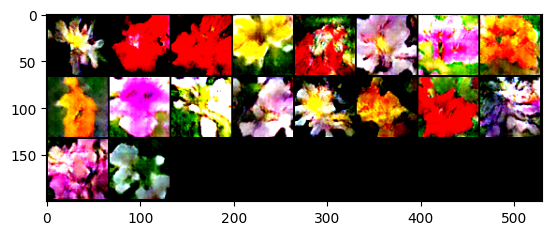

100%|██████████| 103/103 [00:09<00:00, 10.31it/s]


epoch: 42, lossD:0.3437004043964796, lossG:7.586040686635138,lossG_fake:4.027831020864468, lossG_real:3.5582096750296435 ,equality:0.46962134583482484


evaluate:81.81672668457031,kid_mean:0.06154152750968933, kid_std:0.03942950442433357,kid_:(tensor(0.0615), tensor(0.0394))


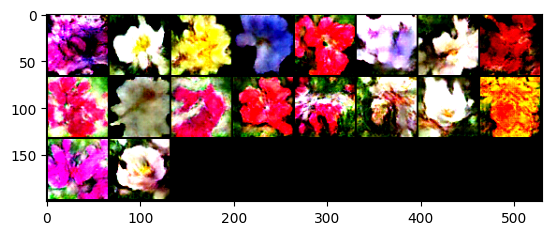

100%|██████████| 103/103 [00:10<00:00, 10.27it/s]


epoch: 43, lossD:0.31210461821298574, lossG:7.614001792611428,lossG_fake:4.0687362869966375, lossG_real:3.5452655229753662 ,equality:0.5234707640212712


evaluate:81.67994689941406,kid_mean:0.07018890976905823, kid_std:0.04288117215037346,kid_:(tensor(0.0702), tensor(0.0429))


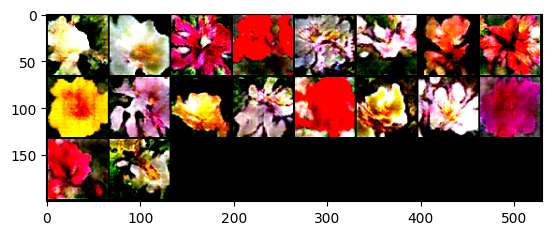

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 44, lossD:0.29937761806819624, lossG:7.641810514394519,lossG_fake:4.088014630438055, lossG_real:3.553795901317041 ,equality:0.5342187291210139


evaluate:81.24109649658203,kid_mean:0.0662858858704567, kid_std:0.03908975422382355,kid_:(tensor(0.0663), tensor(0.0391))


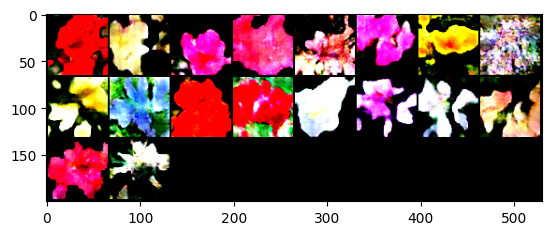

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 45, lossD:0.2857586049375314, lossG:7.782819960881206,lossG_fake:4.145865546846853, lossG_real:3.636954408247494 ,equality:0.508911138599359


evaluate:80.81842803955078,kid_mean:0.06754503399133682, kid_std:0.040746551007032394,kid_:(tensor(0.0675), tensor(0.0407))


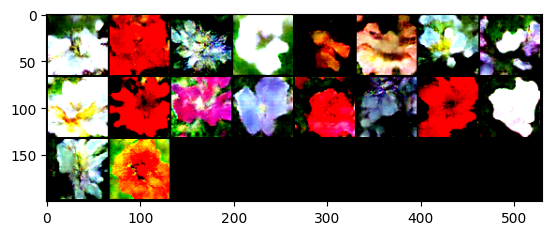

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 46, lossD:0.32127733962628446, lossG:7.69728481885299,lossG_fake:4.064426035556979, lossG_real:3.632858783296011 ,equality:0.4315672522609679


evaluate:79.10956573486328,kid_mean:0.06426559388637543, kid_std:0.04279063269495964,kid_:(tensor(0.0643), tensor(0.0428))


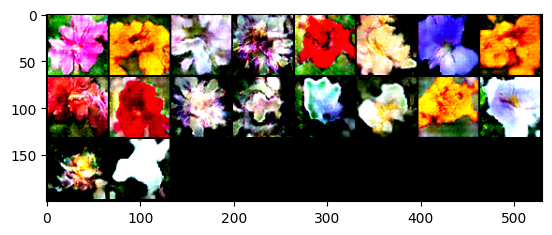

100%|██████████| 103/103 [00:09<00:00, 10.36it/s]


epoch: 47, lossD:0.3649547468436864, lossG:7.620441978417554,lossG_fake:4.049826913666957, lossG_real:3.5706150505727936 ,equality:0.4792118630941631


evaluate:78.367919921875,kid_mean:0.06302203983068466, kid_std:0.041033051908016205,kid_:(tensor(0.0630), tensor(0.0410))


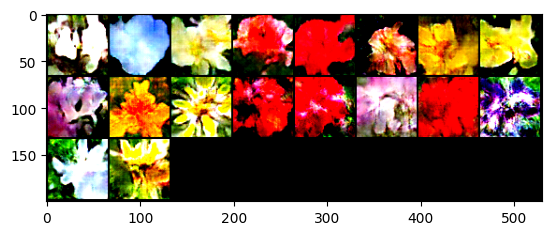

100%|██████████| 103/103 [00:10<00:00, 10.03it/s]


epoch: 48, lossD:0.30614319599224527, lossG:7.653156160150917,lossG_fake:4.038287432448378, lossG_real:3.614868704555104 ,equality:0.42341872789327395


evaluate:78.36648559570312,kid_mean:0.053920578211545944, kid_std:0.0401107557117939,kid_:(tensor(0.0539), tensor(0.0401))


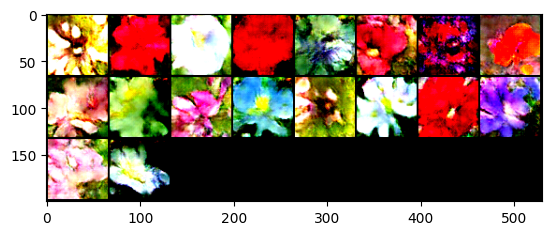

100%|██████████| 103/103 [00:10<00:00, 10.29it/s]


epoch: 49, lossD:0.26534962796976846, lossG:7.837117334014004,lossG_fake:4.16022075727148, lossG_real:3.6768965732704086 ,equality:0.48332418400107136


evaluate:77.77597045898438,kid_mean:0.07585451751947403, kid_std:0.04256964474916458,kid_:(tensor(0.0759), tensor(0.0426))


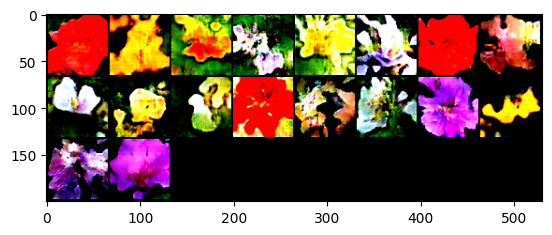

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

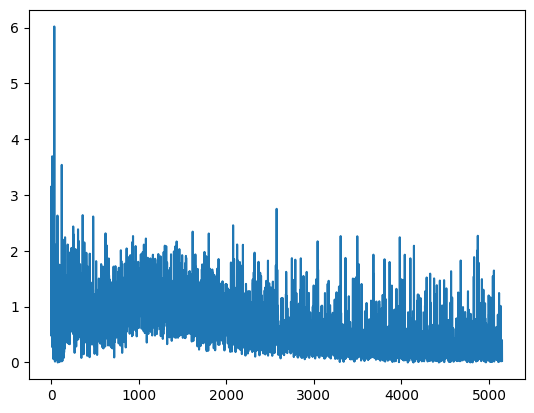

In [45]:
plt.plot(raw_lossesD)

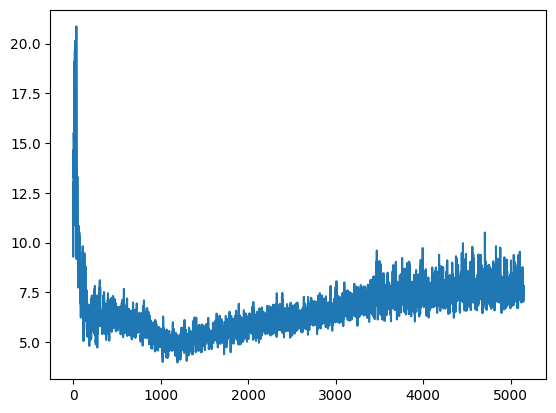

In [46]:
plt.plot(raw_lossesG)

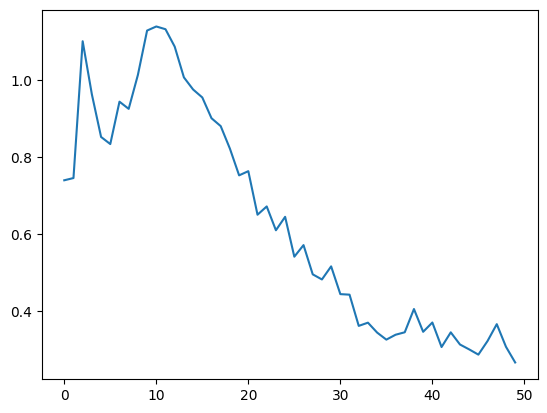

In [47]:
plt.plot(lossesD)

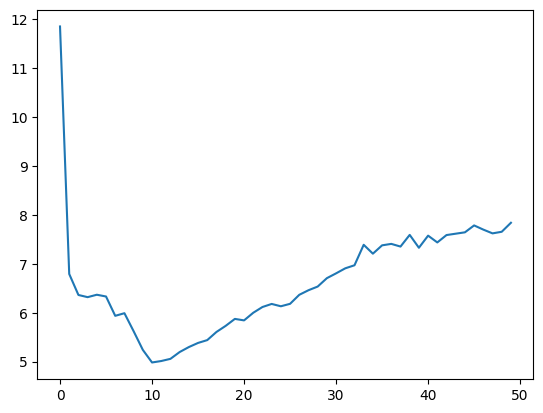

In [48]:
plt.plot(lossesG)

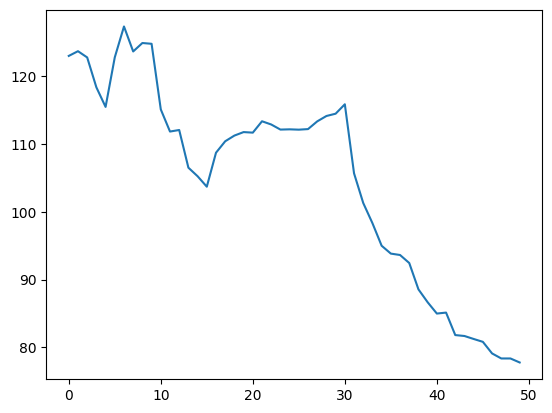

In [49]:
plt.plot(fid_)

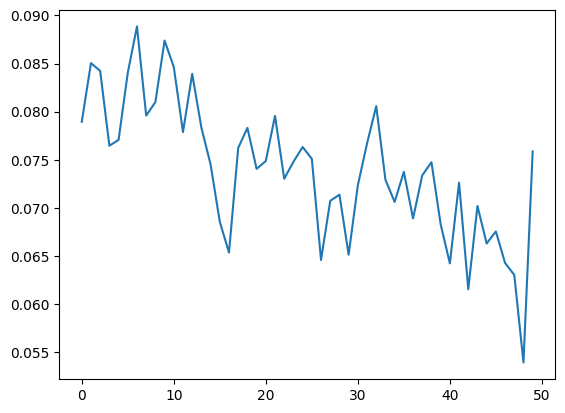

In [50]:
plt.plot(kid_mean_)

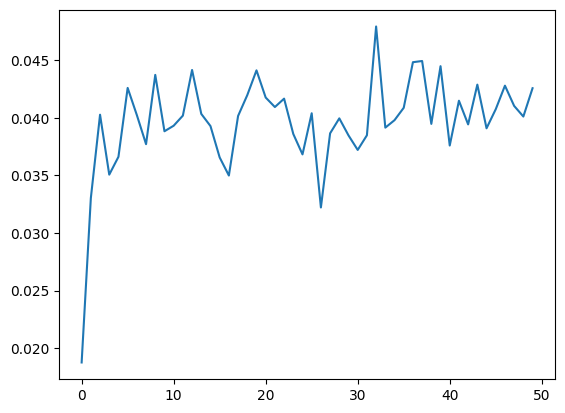

In [51]:
plt.plot(kid_std_)

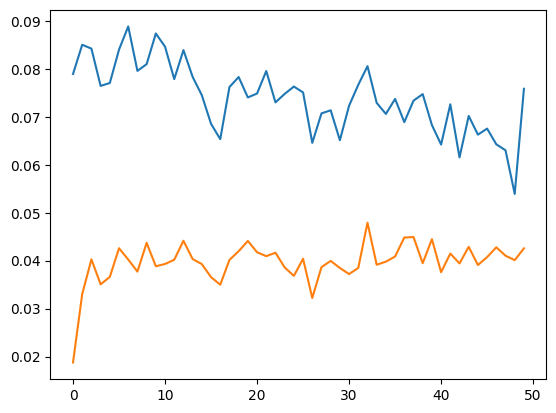

In [52]:
plt.plot(kid_score)

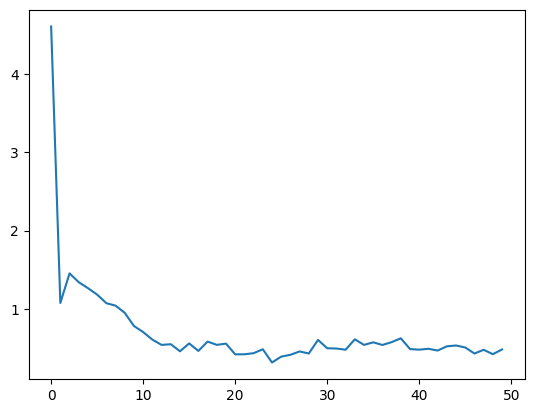

In [53]:
plt.plot(d_equality)

In [54]:
import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.6 MB/s eta 0:00:00
fid  tensor(77.2791)
kid  (tensor(0.0676), tensor(0.0461))
PSNR tensor(79.4832)
SSIM値: 0.9988757879711873
